In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

### data is obtained from https://www.kaggle.com/nareshbhat/health-care-data-set-on-heart-attack-possibility

In [7]:
data = pd.read_csv('data.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [11]:
cleaned_data = data.drop(columns=['age','sex'])

## PCA

In [12]:
X = cleaned_data.values[:, :-1]
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

In [13]:
pca_std = PCA(n_components=2)
pca = PCA(n_components=2)

In [14]:
X_reduced_nostd = pca.fit_transform(X)
X_reduced_std = pca_std.fit_transform(X_std)

In [15]:
pca.explained_variance_ratio_

array([0.76395314, 0.14941205])

In [16]:
pca_std.explained_variance_ratio_

array([0.2320786 , 0.12351757])

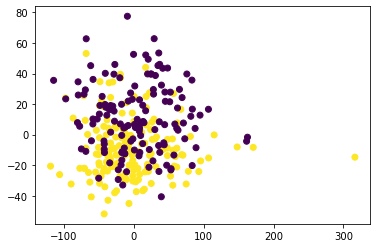

In [17]:
plt.scatter(X_reduced_nostd[:, 0], X_reduced_nostd[:, 1], c=data.values[:, -1])

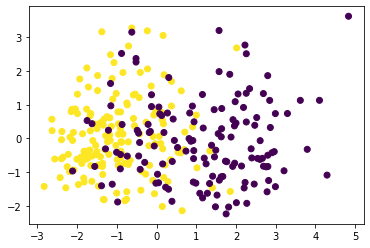

In [18]:
plt.scatter(X_reduced_std[:, 0], X_reduced_std[:, 1], c=data.values[:, -1])

## t-SNE

In [19]:
tsne = TSNE(n_components=2)

In [20]:
X_t = tsne.fit_transform(X)

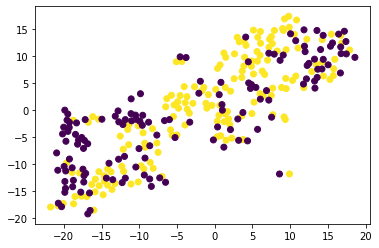

In [21]:
plt.scatter(X_t[:, 0], X_t[:, 1], c=data.values[:, -1])

In [22]:
X_std_t = tsne.fit_transform(X_std)

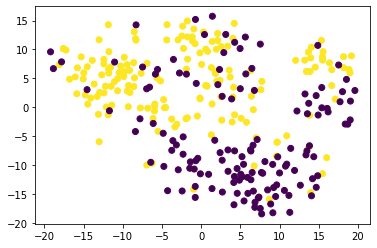

In [23]:
plt.scatter(X_std_t[:, 0], X_std_t[:, 1], c=data.values[:, -1])

## Image quantization

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [25]:
n_colors = [64, 32, 16, 8]

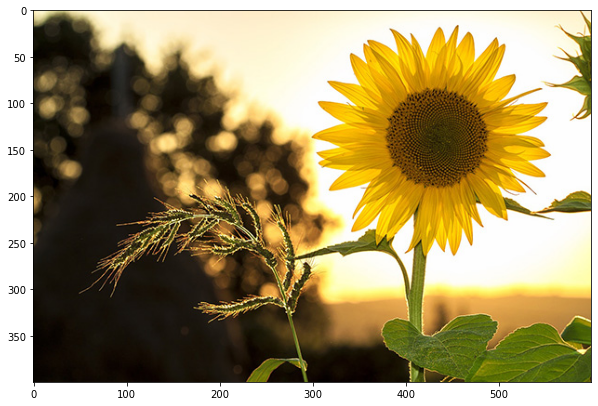

In [26]:
image = imread('sunflower.jpg')
plt.figure(figsize=(10,7))
plt.imshow(image)

In [27]:
image = image / 255

In [28]:
w, h, d = image.shape
image_array = image.reshape(w * h, d)

In [29]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [30]:
image_array_sample = shuffle(image_array, random_state=0)[:3000]

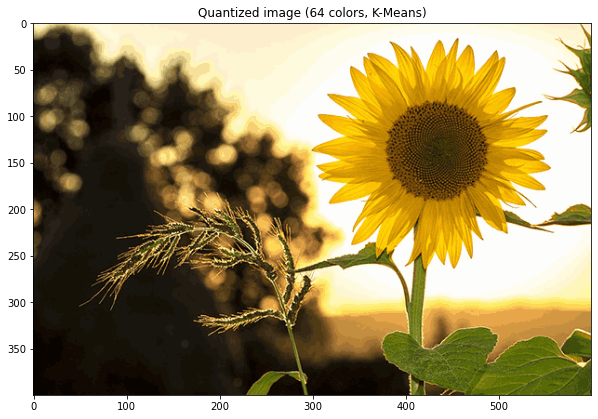

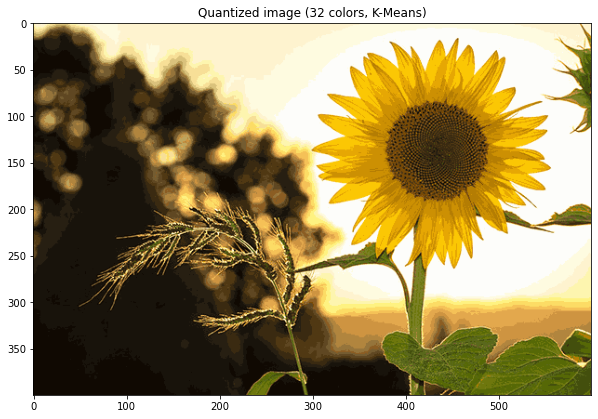

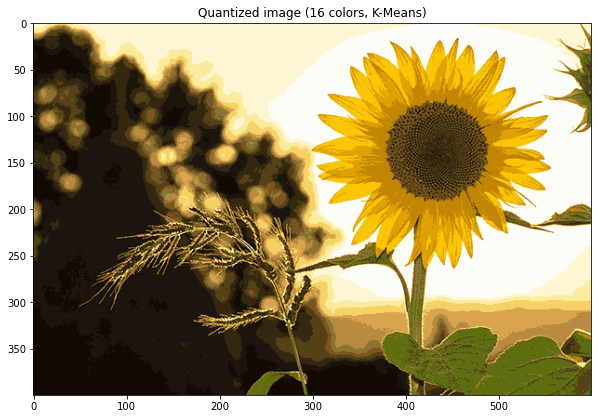

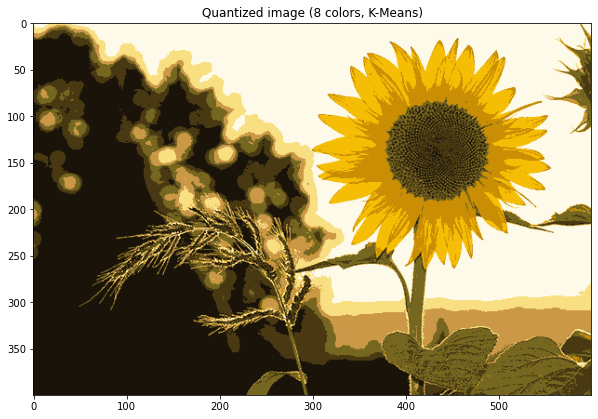

In [31]:
for n in n_colors:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    plt.figure(figsize=(10,7))
    plt.title(f'Quantized image ({n} colors, K-Means)')
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
    plt.show()

## Clustering

In [32]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [33]:
N = 4
X, y = make_blobs(n_features=2, centers=N, n_samples=500)

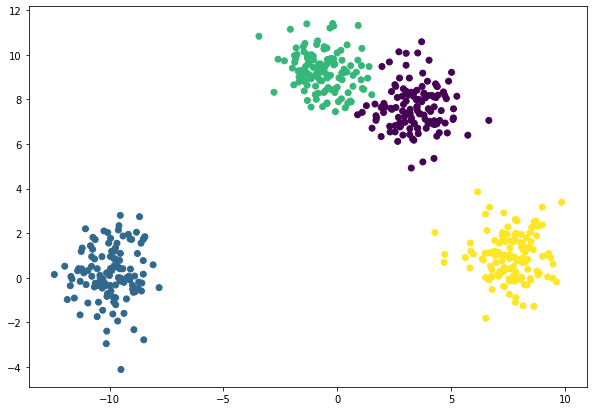

In [34]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y)

For n_clusters = 3 The average silhouette_score is : 0.7529167063853569
For n_clusters = 4 The average silhouette_score is : 0.7113143455030074
For n_clusters = 5 The average silhouette_score is : 0.5845735027388965


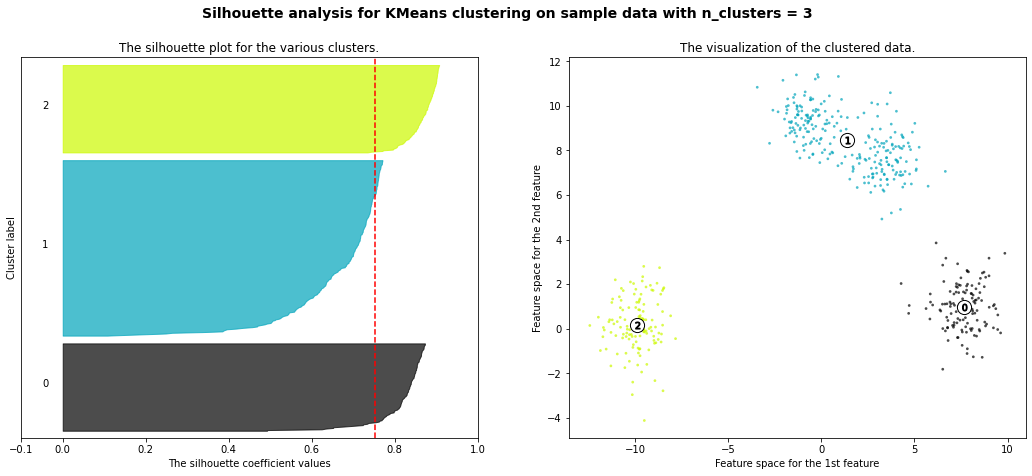

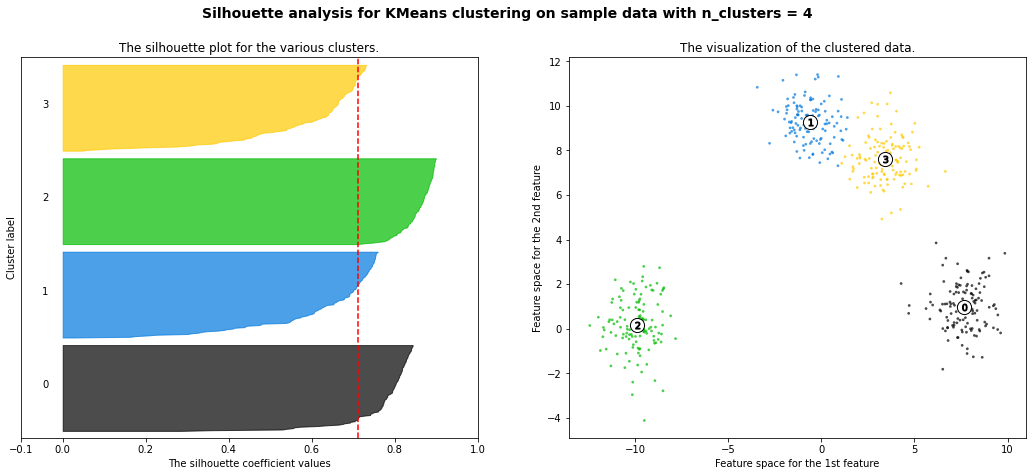

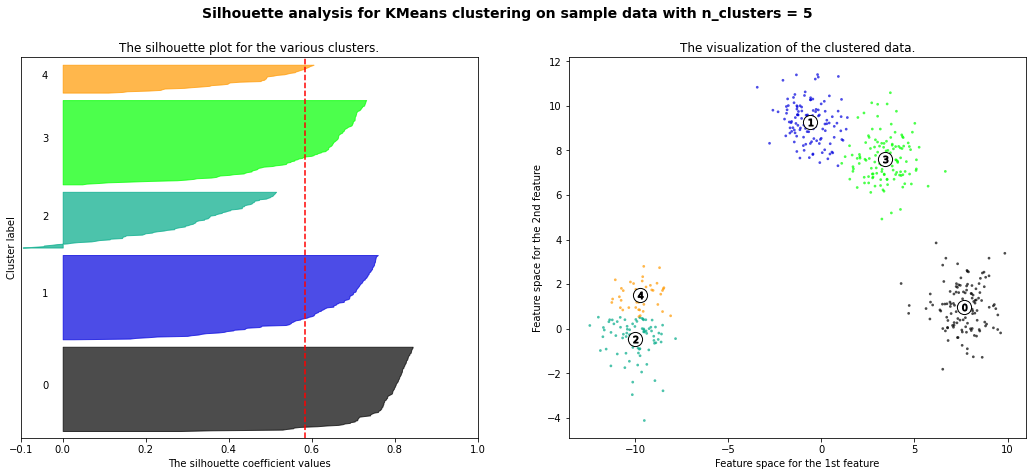

In [35]:
range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Gaussian Mixture

In [36]:
from sklearn.mixture import GaussianMixture
from numpy.random import multivariate_normal

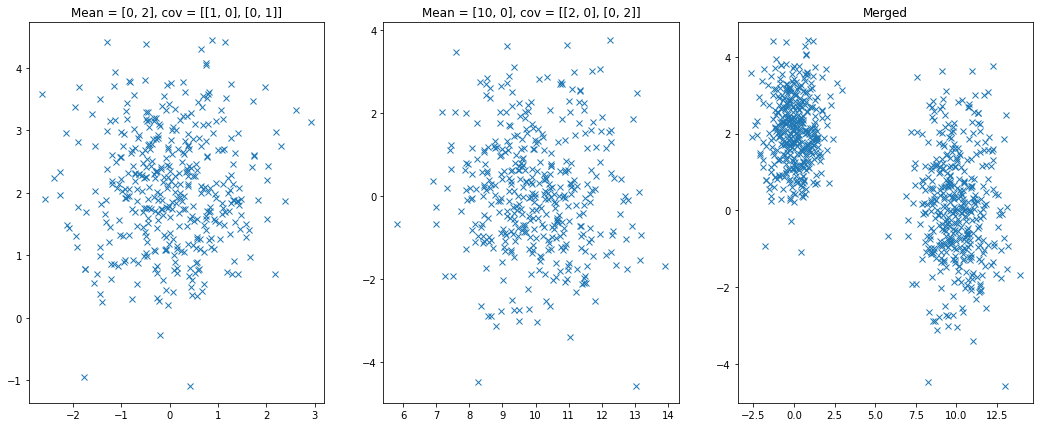

In [37]:
mean_1 = [0, 2]
mean_2 = [10, 0]

cov_1 = [[1, 0], 
         [0, 1]]
cov_2 = [[2, 0], 
         [0, 2]]

g_1 = np.array(multivariate_normal(mean_1, cov_1, 400))
g_2 = np.array(multivariate_normal(mean_2, cov_2, 400))

g_3 = np.concatenate((g_1, g_2), axis=0)

fig, subplots = plt.subplots(1, 3, figsize=(18, 7))
subplots[0].plot(g_1[:, 0], g_1[:, 1], 'x')
subplots[0].set_title('Mean = {}, cov = {}'.format(mean_1, cov_1))
subplots[1].plot(g_2[:, 0], g_2[:, 1], 'x')
subplots[1].set_title('Mean = {}, cov = {}'.format(mean_2, cov_2))
subplots[2].set_title('Merged')
subplots[2].plot(g_3[:, 0], g_3[:, 1], 'x')
plt.show()

In [38]:
clf = GaussianMixture(n_components=2, covariance_type='diag', random_state=0)
clf_predicted = clf.fit(g_3 ).predict(g_3)

In [39]:
clf_predicted.shape

(800,)

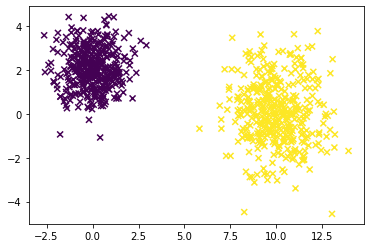

In [40]:
plt.scatter(x=g_3[:, 0], y=g_3[:, 1], c=clf_predicted, marker='x')
plt.show()

In [41]:
print('Means_1 = {}, means_2 = {}'.format(clf.means_[0], clf.means_[1]))
print('Cov_1')
print(clf.covariances_[0])
print('Cov_2')
print(clf.covariances_[1])

Means_1 = [0.01545457 2.06884246], means_2 = [10.0020595   0.06509124]
Cov_1
[0.90270426 0.86370311]
Cov_2
[1.73301808 2.0210427 ]


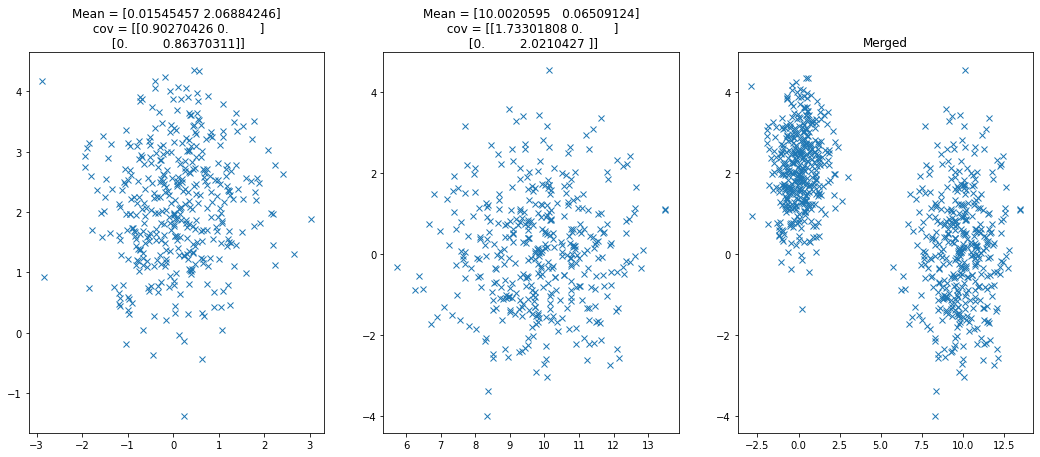

In [42]:
new_g_1 = np.array(multivariate_normal(clf.means_[0], np.diag(clf.covariances_[0]), 400))
new_g_2 = np.array(multivariate_normal(clf.means_[1], np.diag(clf.covariances_[1]), 400))
new_g_3 = np.concatenate((new_g_1, new_g_2), axis=0)

fig, subplots = plt.subplots(1, 3, figsize=(18, 7))
subplots[0].plot(new_g_1[:, 0], new_g_1[:, 1], 'x')
subplots[0].set_title('Mean = {}\n cov = {}'.format(clf.means_[0], np.diag(clf.covariances_[0])))
subplots[1].plot(new_g_2[:, 0], new_g_2[:, 1], 'x')
subplots[1].set_title('Mean = {}\n cov = {}'.format(clf.means_[1], np.diag(clf.covariances_[1])))
subplots[2].set_title('Merged')
subplots[2].plot(new_g_3[:, 0], new_g_3[:, 1], 'x')
plt.show()

## Text processing
### data is obtained from https://www.kaggle.com/nltkdata/movie-review

In [43]:
import nltk
import os
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [44]:
# download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rtmk_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rtmk_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rtmk_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [46]:
data_pos_dir = 'movie_reviews/pos/'
data_neg_dir = 'movie_reviews/neg/'

In [47]:
class MovieReviewProcessor:
    stop_words = stopwords.words("english")
    punctuation_re = re.compile("[.;:!\'?,\"()\[\]]")

    def __init__(self, data_pos_dir, data_neg_dir):
        self.data_pos_dir = data_pos_dir
        self.data_neg_dir = data_neg_dir
        
        self.preprocessed_data_pos = None
        self.preprocessed_data_neg = None

    def load_corpus(self, directory):
        for file_name in os.listdir(directory):
            with open(directory + file_name, encoding="utf8") as datafile:
                yield datafile.read()
    
    def load_data(self):
        self.preprocessed_data_pos = self.preprocess_corpus(self.data_pos_dir)
        self.data_pos_targets = np.ones(len(self.preprocessed_data_pos))
        self.preprocessed_data_neg = self.preprocess_corpus(self.data_neg_dir)
        self.data_neg_targets = np.zeros(len(self.preprocessed_data_neg))
        
    def preprocess_corpus(self, directory):
        corpus = []
        for text in self.load_corpus(directory):
            corpus.append(MovieReviewProcessor.join_to_str(
                  MovieReviewProcessor.lemmatize(
                  MovieReviewProcessor.delete_stop_words(
                  MovieReviewProcessor.tokenize(
                  MovieReviewProcessor.delete_punctuation(text))))))
        return corpus
    
    def show_pos_wordcloud(self):
        wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(self.preprocessed_data_pos))
        
        fig = plt.figure(1, figsize=(12, 12))
        plt.axis('off')
        fig.suptitle("Top words from positive reviews", fontsize=20)
        fig.subplots_adjust(top=2.3)
            
        plt.imshow(wordcloud)
        plt.show()
        
    def show_neg_wordcloud(self):
        wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(' '.join(self.preprocessed_data_neg))
        
        fig = plt.figure(1, figsize=(12, 12))
        plt.axis('off')
        fig.suptitle("Top words from negative reviews", fontsize=20)
        fig.subplots_adjust(top=2.3)
            
        plt.imshow(wordcloud)
        plt.show()
    
    @staticmethod
    def delete_stop_words(document):
        return [word for word in document if word not in MovieReviewProcessor.stop_words]
    
    @staticmethod
    def delete_punctuation(document):
        return MovieReviewProcessor.punctuation_re.sub("", document.lower())
    
    @staticmethod
    def tokenize(document):
        return word_tokenize(document)
    
    @staticmethod
    def lemmatize(document):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in document]
    
    @staticmethod
    def join_to_str(document):
        return ' '.join(document)
        
    def get_features(self):
        clean_reviews = self.preprocessed_data_pos + self.preprocessed_data_neg
        return TfidfVectorizer().fit_transform(clean_reviews)
    
    def get_labels(self):
        return np.concatenate([self.data_pos_targets, self.data_neg_targets])
        
    def test_features():
        pass
        

In [48]:
processor = MovieReviewProcessor(data_pos_dir, data_neg_dir)

In [49]:
processor.load_data()

In [50]:
X = processor.get_features()
y = processor.get_labels()

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75)

In [52]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.476
Accuracy for C=0.05: 0.72
Accuracy for C=0.25: 0.81
Accuracy for C=0.5: 0.824
Accuracy for C=1: 0.836


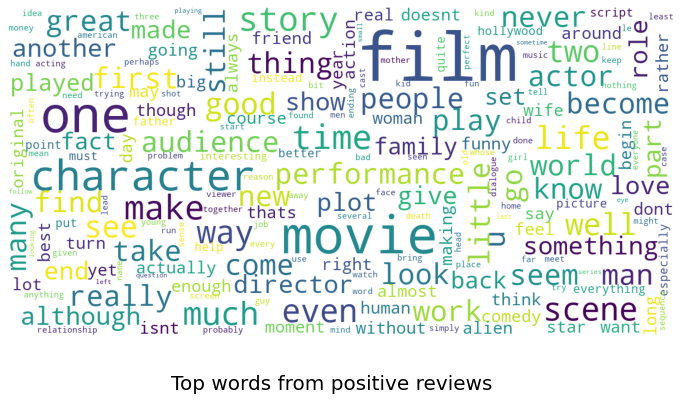

In [53]:
processor.show_pos_wordcloud()

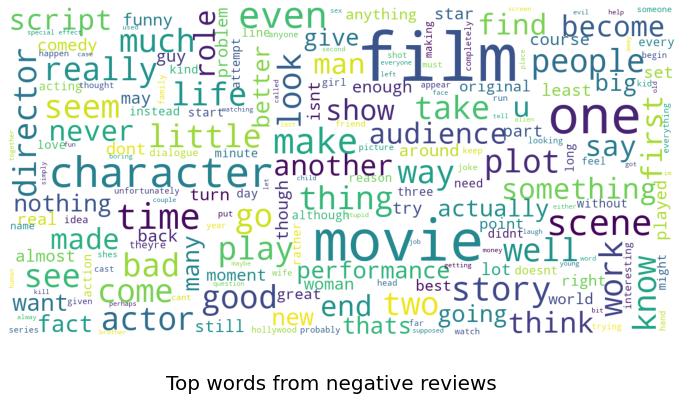

In [54]:
processor.show_neg_wordcloud()